In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd
from glob import glob
import tqdm
import argparse
import tqdm
from collections import defaultdict, Counter
from PIL import Image
import cv2

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, cuda
from torch.autograd import Variable 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import CenterCrop

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

# from efficientnet_pytorch import EfficientNet
import torchvision.models as models

In [2]:
import os
import math
import random
import numpy as np
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

In [3]:
sub = pd.read_csv("../D_WEATHER/input/sample_submission.csv")
sub.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,029858_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,029858_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,029858_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,029858_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### R90

In [4]:
train_path = '../D_WEATHER/input/train'
train_files = sorted(glob(train_path + '/*'))
train_r90_path = '../D_WEATHER/r90/train'
train_r90_files = sorted(glob(train_r90_path + '/*'))

test_path = '../D_WEATHER/input/test'
test_files = sorted(glob(test_path + '/*'))
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [12]:
total_files = train_files + train_r90_files

In [20]:
total_files = []
for i in range(len(train_files)):
    total_files.append(train_files[i])
    total_files.append(train_r90_files[i])

In [22]:
train_df = make_df(total_files)
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/input/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/r90/train/subset_010462_01.npy,10462,1
2,../D_WEATHER/input/train/subset_010462_02.npy,10462,2
3,../D_WEATHER/r90/train/subset_010462_02.npy,10462,2
4,../D_WEATHER/input/train/subset_010462_03.npy,10462,3


In [23]:
test_df = make_df(test_files)
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/input/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/input/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/input/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/input/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/input/test/subset_029858_07.npy,29858,7


In [24]:
train_df.shape, test_df.shape

((152690, 3), (2416, 3))

In [25]:
train_df.to_csv("../D_WEATHER/input/train_r90_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_r90_df.csv", index=False)

### Rotate 90,180,270

In [4]:
train_path = '../D_WEATHER/input/train'
train_files = sorted(glob(train_path + '/*'))
train_r90_path = '../D_WEATHER/r90/train'
train_r90_files = sorted(glob(train_r90_path + '/*'))
train_r180_path = '../D_WEATHER/r180/train'
train_r180_files = sorted(glob(train_r180_path + '/*'))
train_r270_path = '../D_WEATHER/r270/train'
train_r270_files = sorted(glob(train_r270_path + '/*'))

test_path = '../D_WEATHER/input/test'
test_files = sorted(glob(test_path + '/*'))
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [5]:
total_files = train_files + train_r90_files + train_r180_files + train_r270_files

In [6]:
total_files = []
for i in range(len(train_files)):
    total_files.append(train_files[i])
    total_files.append(train_r90_files[i])
    total_files.append(train_r180_files[i])
    total_files.append(train_r270_files[i])

In [7]:
len(total_files)

305380

In [8]:
train_df = make_df(total_files)
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/input/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/r90/train/subset_010462_01.npy,10462,1
2,../D_WEATHER/r180/train/subset_010462_01.npy,10462,1
3,../D_WEATHER/r270/train/subset_010462_01.npy,10462,1
4,../D_WEATHER/input/train/subset_010462_02.npy,10462,2


In [10]:
test_df = make_df(test_files)
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/input/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/input/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/input/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/input/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/input/test/subset_029858_07.npy,29858,7


In [11]:
train_df.shape, test_df.shape

((305380, 3), (2416, 3))

In [12]:
train_df.to_csv("../D_WEATHER/input/train_rotate_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_rotate_df.csv", index=False)

### 7 Ch

In [4]:
train_path = '../D_WEATHER/7ch/train'
train_files = sorted(glob(train_path + '/*'))
test_path = '../D_WEATHER/7ch/test'
test_files = sorted(glob(test_path + '/*'))
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [5]:
train_df = make_df(train_files)
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/7ch/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/7ch/train/subset_010462_02.npy,10462,2
2,../D_WEATHER/7ch/train/subset_010462_03.npy,10462,3
3,../D_WEATHER/7ch/train/subset_010462_04.npy,10462,4
4,../D_WEATHER/7ch/train/subset_010462_05.npy,10462,5


In [6]:
test_df = make_df(test_files)
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/7ch/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/7ch/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/7ch/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/7ch/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/7ch/test/subset_029858_07.npy,29858,7


In [7]:
train_df.to_csv("../D_WEATHER/input/train_7ch_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_7ch_df.csv", index=False)

### 3 Ch

In [5]:
train_path = '../D_WEATHER/3ch/train'
train_files = sorted(glob(train_path + '/*'))
test_path = '../D_WEATHER/3ch/test'
test_files = sorted(glob(test_path + '/*'))
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [6]:
train_df = make_df(train_files)
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/3ch/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/3ch/train/subset_010462_02.npy,10462,2
2,../D_WEATHER/3ch/train/subset_010462_03.npy,10462,3
3,../D_WEATHER/3ch/train/subset_010462_04.npy,10462,4
4,../D_WEATHER/3ch/train/subset_010462_05.npy,10462,5


In [7]:
test_df = make_df(test_files)
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/3ch/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/3ch/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/3ch/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/3ch/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/3ch/test/subset_029858_07.npy,29858,7


In [8]:
train_df.to_csv("../D_WEATHER/input/train_3ch_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_3ch_df.csv", index=False)

### 5 Ch

In [8]:
train_path = '../D_WEATHER/5ch/train'
train_files = sorted(glob(train_path + '/*'))
test_path = '../D_WEATHER/5ch/test'
test_files = sorted(glob(test_path + '/*'))
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [9]:
train_df = make_df(train_files)
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/5ch/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/5ch/train/subset_010462_02.npy,10462,2
2,../D_WEATHER/5ch/train/subset_010462_03.npy,10462,3
3,../D_WEATHER/5ch/train/subset_010462_04.npy,10462,4
4,../D_WEATHER/5ch/train/subset_010462_05.npy,10462,5


In [10]:
test_df = make_df(test_files)
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/5ch/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/5ch/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/5ch/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/5ch/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/5ch/test/subset_029858_07.npy,29858,7


In [11]:
train_df.to_csv("../D_WEATHER/input/train_5ch_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_5ch_df.csv", index=False)

# Create Normal dataframe

In [60]:
train_path = '../D_WEATHER/normal/train'
train_files = sorted(glob(train_path + '/*'))
test_path = '../D_WEATHER/normal/test'
test_files = sorted(glob(test_path + '/*'))

In [61]:
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [62]:
train_df = make_df(train_files)

In [63]:
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/normal/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/normal/train/subset_010462_02.npy,10462,2
2,../D_WEATHER/normal/train/subset_010462_03.npy,10462,3
3,../D_WEATHER/normal/train/subset_010462_04.npy,10462,4
4,../D_WEATHER/normal/train/subset_010462_05.npy,10462,5


In [64]:
test_df = make_df(test_files)
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/normal/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/normal/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/normal/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/normal/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/normal/test/subset_029858_07.npy,29858,7


In [65]:
train_df.to_csv("../D_WEATHER/input/train_normal_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_normal_df.csv", index=False)

# Create Clean dataframe

In [4]:
train_path = '../D_WEATHER/clean/train'
train_files = sorted(glob(train_path + '/*'))

In [5]:
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [6]:
train_df = make_df(train_files)

In [7]:
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/clean/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/clean/train/subset_010462_02.npy,10462,2
2,../D_WEATHER/clean/train/subset_010462_03.npy,10462,3
3,../D_WEATHER/clean/train/subset_010462_04.npy,10462,4
4,../D_WEATHER/clean/train/subset_010462_05.npy,10462,5


In [8]:
train_df.to_csv("../D_WEATHER/input/train_clean_df.csv", index=False)

# Create Outlier dataframe

In [9]:
train_path = '../D_WEATHER/outlier/train'
train_files = sorted(glob(train_path + '/*'))

In [10]:
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [11]:
train_df = make_df(train_files)

In [12]:
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/outlier/train/subset_010462_01.npy,10462,1
1,../D_WEATHER/outlier/train/subset_010462_02.npy,10462,2
2,../D_WEATHER/outlier/train/subset_010462_03.npy,10462,3
3,../D_WEATHER/outlier/train/subset_010462_04.npy,10462,4
4,../D_WEATHER/outlier/train/subset_010462_05.npy,10462,5


In [13]:
train_df.to_csv("../D_WEATHER/input/train_outlier_df.csv", index=False)

# Create dataframe

In [3]:
train_path = '../D_WEATHER/input/train'
train_files = sorted(glob(train_path + '/*'))

In [4]:
test_path = '../D_WEATHER/input/test'
test_files = sorted(glob(test_path + '/*'))

In [5]:
train_files[:5]

['../D_WEATHER//input/train/subset_010462_01.npy',
 '../D_WEATHER//input/train/subset_010462_02.npy',
 '../D_WEATHER//input/train/subset_010462_03.npy',
 '../D_WEATHER//input/train/subset_010462_04.npy',
 '../D_WEATHER//input/train/subset_010462_05.npy']

In [6]:
test_files[:5]

['../D_WEATHER/input/test/subset_029858_01.npy',
 '../D_WEATHER/input/test/subset_029858_02.npy',
 '../D_WEATHER/input/test/subset_029858_03.npy',
 '../D_WEATHER/input/test/subset_029858_05.npy',
 '../D_WEATHER/input/test/subset_029858_07.npy']

In [7]:
def make_df(files):
    df = pd.DataFrame({"path":files})
    df['orbit'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[0])
    df['orbit_subset'] = df['path'].apply(lambda x: x.split("subset_")[1].split("_")[1].split(".")[0])
    
    df['orbit'] = df['orbit'].astype(int)
    df['orbit_subset'] = df['orbit_subset'].astype(int)
    return df

In [8]:
train_df = make_df(train_files)

In [9]:
train_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER//input/train/subset_010462_01.npy,10462,1
1,../D_WEATHER//input/train/subset_010462_02.npy,10462,2
2,../D_WEATHER//input/train/subset_010462_03.npy,10462,3
3,../D_WEATHER//input/train/subset_010462_04.npy,10462,4
4,../D_WEATHER//input/train/subset_010462_05.npy,10462,5


In [10]:
test_df = make_df(test_files)

In [19]:
test_df.head()

,path,orbit,orbit_subset
0,../D_WEATHER/input/test/subset_029858_01.npy,29858,1
1,../D_WEATHER/input/test/subset_029858_02.npy,29858,2
2,../D_WEATHER/input/test/subset_029858_03.npy,29858,3
3,../D_WEATHER/input/test/subset_029858_05.npy,29858,5
4,../D_WEATHER/input/test/subset_029858_07.npy,29858,7


In [13]:
train_df.to_csv("../D_WEATHER/input/train_df.csv", index=False)
test_df.to_csv("../D_WEATHER/input/test_df.csv", index=False)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

image_sample = np.load('../D_WEATHER/5ch/train/subset_010462_02.npy')

In [2]:
image_sample[:,:,:].shape

(40, 40, 6)

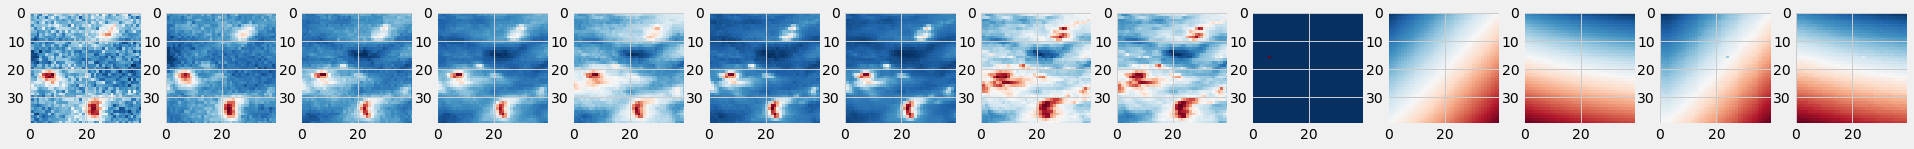

In [32]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(14):
    plt.subplot(1,14,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

# plt.subplot(1,14,14)
# plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

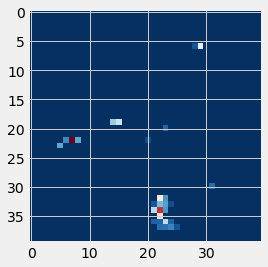

In [33]:
plt.imshow(image_sample[:, :, -1], cmap=color_map)

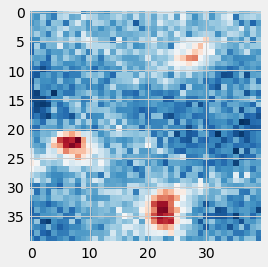

In [34]:
plt.imshow(image_sample[:, :, 0], cmap=color_map)

In [35]:
image_sample.shape

(40, 40, 15)

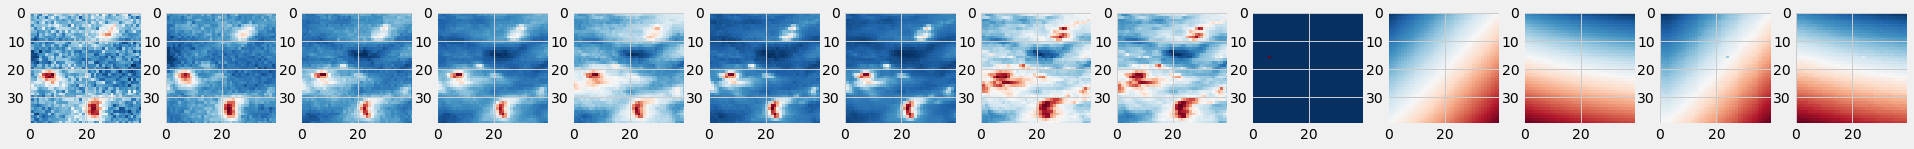

In [36]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(14):
    plt.subplot(1,14,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

# plt.subplot(1,14,14)
# plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [37]:
def clahe(img, clip_limit=1.0, tile_grid_size=(16, 16)):
    if img.dtype != np.uint8:
        raise TypeError("clahe supports only uint8 inputs")

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    if len(img.shape) == 2:
        img = clahe.apply(img)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img[:, :, 0] = clahe.apply(img[:, :, 0])
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

    return img

In [44]:
import cv2
img = clahe(image_sample[:, :, :4].astype(np.uint8))

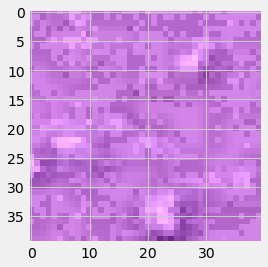

In [45]:
plt.imshow(img, cmap=color_map)

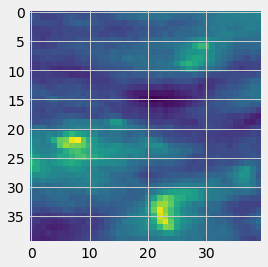

In [47]:
plt.imshow(image_sample[:, :, 4])

In [48]:
image_sample.shape

(40, 40, 15)

In [ ]:
def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [49]:
# img = img.reshape(HEIGHT, WIDTH)
image_resized = cv2.resize(image_sample, (80, 80), interpolation = cv2.INTER_AREA)


In [51]:
image_resized.shape

(80, 80, 15)

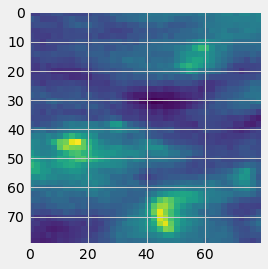

In [53]:
plt.imshow(image_resized[:, :, 4])

In [50]:
image_sample[:, :, 0].max()

180.29708862304688

In [16]:
image_sample[:, :, 0].std()

1.1332296177109589